In [29]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [30]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

525


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,673332d7597d678ec85a3c829f02f47ff80356cd,wrong-mome,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.116667,0.151677,0.21,0.264569,0.10,0.120000,0.04,0.070462,COT,2
1,5bcf06a7621f96e6319c54f6111dbeeeb831a3b6,wacky-juts,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cot/format-think.txt,cq.txt,empty.json,...,0.053333,0.102588,0.06,0.134806,0.07,0.108380,0.03,0.064579,COT,0
2,601025d8649e1c8a131d4ee5aa1fc2321800353d,focal-bort,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cot/excellent-format-reasoning.txt,cq.txt,cot-2-shot.json,...,0.163333,0.195460,0.26,0.318119,0.18,0.201705,0.05,0.066556,COT,2
3,ae06cd16088072e3c045d9037627bffbdd42a6d4,yolky-whit,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cot/excellent-format-reasoning.txt,cq.txt,empty.json,...,0.060000,0.082742,0.08,0.109836,0.06,0.084391,0.04,0.054000,COT,0
4,7f07eeb51d8036d8a74f54aacb59dc33bc2744a7,lippy-joss,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cot/format-reasoning.txt,cq.txt,cot-2-shot.json,...,0.120000,0.173731,0.21,0.298313,0.11,0.155691,0.04,0.067190,COT,2


In [31]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [32]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [33]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run


In [34]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [35]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
193,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.3,0.670000,0.767578,0.67,0.776727,0.75,0.821357,0.59,0.704651
174,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.640000,0.760261,0.66,0.766757,0.71,0.821516,0.55,0.692510
195,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.653333,0.757212,0.67,0.775579,0.74,0.828048,0.55,0.668009
172,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.3,0.646667,0.756386,0.66,0.773393,0.72,0.814909,0.56,0.680857
168,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.646667,0.754764,0.67,0.771598,0.73,0.821423,0.54,0.671270
169,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.643333,0.754596,0.67,0.770060,0.74,0.825888,0.52,0.667841
190,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.650000,0.753059,0.68,0.786727,0.72,0.801071,0.55,0.671381
171,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.3,0.640000,0.750212,0.67,0.771598,0.73,0.823657,0.52,0.655381
170,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.640000,0.749979,0.68,0.780060,0.72,0.809964,0.52,0.659913
197,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.633333,0.749702,0.65,0.775484,0.69,0.796582,0.56,0.677040


In [37]:
df['params.qa.system_prompt'].unique()

array(['cot/excellent-format-reasoning', 'cot/format-minimal',
       'cot/format-reasoning', 'cot/format-think',
       'cte/excellent-format-few', 'cte/format-few',
       'cte/format-relevant-few', 'direct/excellent-few',
       'direct/helpful-output-format-few',
       'direct/minimal-output-format-few', 'direct/minimal-output-format'],
      dtype=object)

In [38]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.1,0.466667,0.534404,0.530000,0.623323,0.480000,0.533778,0.390000,0.446111
1,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.3,0.458889,0.524348,0.543333,0.640527,0.453333,0.503667,0.380000,0.428852
2,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.5,0.431111,0.496876,0.540000,0.625007,0.420000,0.464119,0.333333,0.401503
3,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.7,0.435556,0.505599,0.533333,0.627743,0.406667,0.468624,0.366667,0.420431
4,COT,cot/excellent-format-reasoning,cq,cot-2-shot,1.0,0.428889,0.490254,0.530000,0.625452,0.413333,0.449841,0.343333,0.395468


In [39]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
56,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.643333,0.753113,0.673333,0.773906,0.730000,0.819092,0.526667,0.666341
133,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,0.586667,0.700681,0.636667,0.746773,0.623333,0.718500,0.500000,0.636770
21,COT,cot/format-minimal,cq,empty,0.1,0.528889,0.632597,0.613333,0.730024,0.553333,0.648429,0.420000,0.519339


## Visualizations

In [108]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["few_shot_examples"].map(str)
    )

    return dataf


In [150]:
def plot_variance(dataf, figsize=(8, 8), legend='auto', legend_loc='lower left'):  
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5, legend=legend)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [151]:
prepared_df = prepare_data(df)
temperature_mask = prepared_df["temperature"] <= 1.0
zero_shot_mask = prepared_df["few_shot_examples"] == 'empty'
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
0,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.1,1,0.456667,0.525739,cot/excellent-format-reasoning | cq | cot-2-shot
1,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.1,2,0.476667,0.541647,cot/excellent-format-reasoning | cq | cot-2-shot
2,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.1,3,0.466667,0.535826,cot/excellent-format-reasoning | cq | cot-2-shot
3,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.3,1,0.466667,0.529890,cot/excellent-format-reasoning | cq | cot-2-shot
4,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.3,2,0.466667,0.536318,cot/excellent-format-reasoning | cq | cot-2-shot
...,...,...,...,...,...,...,...,...,...
520,Direct,direct/minimal-output-format,cq,empty,1.5,2,0.453333,0.572309,direct/minimal-output-format | cq | empty
521,Direct,direct/minimal-output-format,cq,empty,1.5,3,0.470000,0.568480,direct/minimal-output-format | cq | empty
522,Direct,direct/minimal-output-format,cq,empty,2.0,1,0.226667,0.318216,direct/minimal-output-format | cq | empty
523,Direct,direct/minimal-output-format,cq,empty,2.0,2,0.206667,0.292214,direct/minimal-output-format | cq | empty


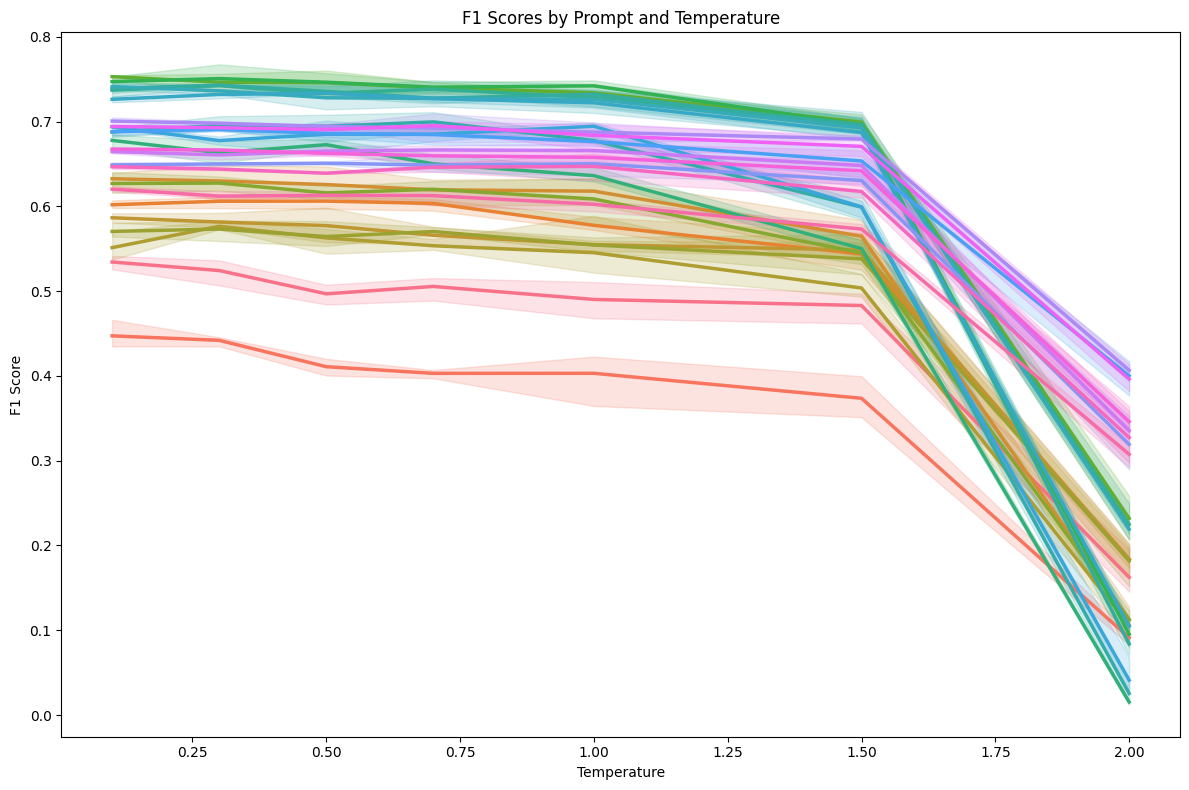

In [152]:
plot_variance(prepared_df, figsize=(12, 8), legend=None)

## Statistical Testing

In [153]:
def two_way_anova(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

### Direct technique

In [154]:
direct_prompt_mask = prepared_df["technique"] == "Direct"
direct_prompt_prepared_df = prepared_df[direct_prompt_mask & temperature_mask]
direct_prompt_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
357,Direct,direct/excellent-few,cq,direct-2-shot,0.1,1,0.580000,0.689019,direct/excellent-few | cq | direct-2-shot
358,Direct,direct/excellent-few,cq,direct-2-shot,0.1,2,0.583333,0.691531,direct/excellent-few | cq | direct-2-shot
359,Direct,direct/excellent-few,cq,direct-2-shot,0.1,3,0.576667,0.683702,direct/excellent-few | cq | direct-2-shot
360,Direct,direct/excellent-few,cq,direct-2-shot,0.3,1,0.580000,0.688629,direct/excellent-few | cq | direct-2-shot
361,Direct,direct/excellent-few,cq,direct-2-shot,0.3,2,0.580000,0.690001,direct/excellent-few | cq | direct-2-shot
...,...,...,...,...,...,...,...,...,...
514,Direct,direct/minimal-output-format,cq,empty,0.7,2,0.500000,0.617590,direct/minimal-output-format | cq | empty
515,Direct,direct/minimal-output-format,cq,empty,0.7,3,0.503333,0.618874,direct/minimal-output-format | cq | empty
516,Direct,direct/minimal-output-format,cq,empty,1.0,1,0.500000,0.607173,direct/minimal-output-format | cq | empty
517,Direct,direct/minimal-output-format,cq,empty,1.0,2,0.476667,0.594131,direct/minimal-output-format | cq | empty


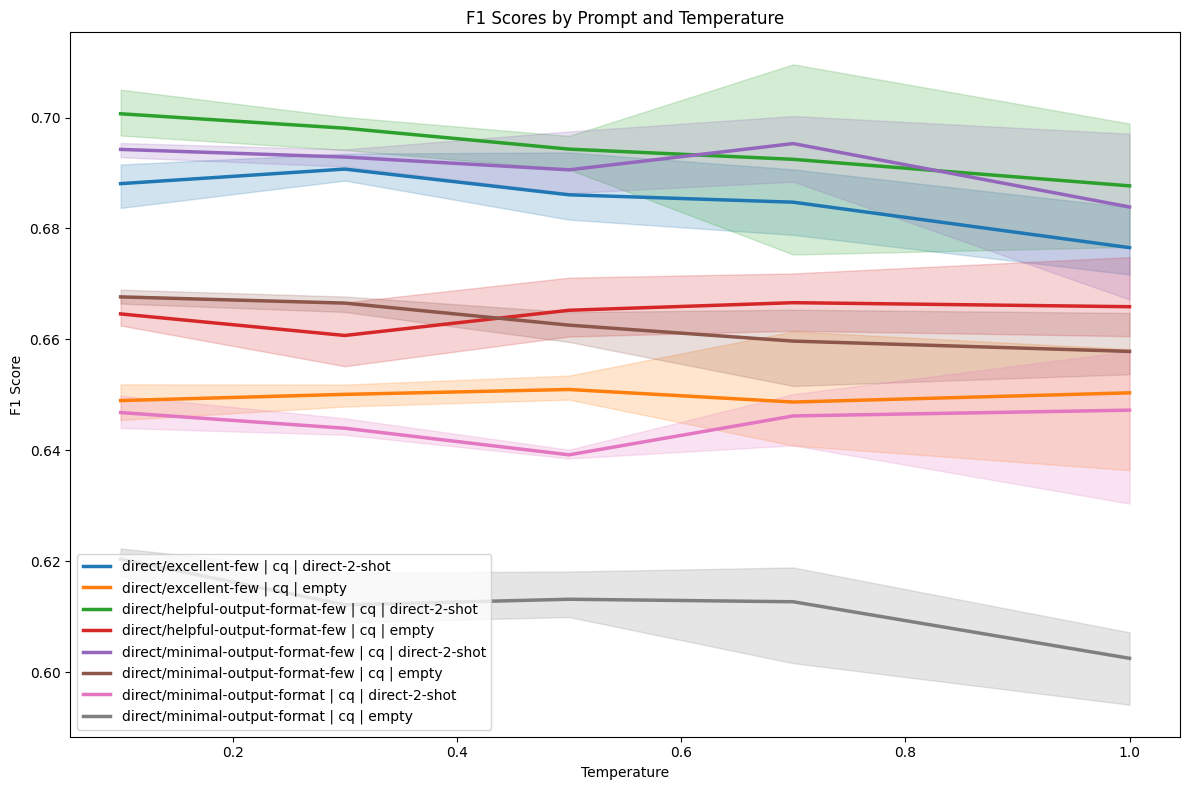

In [155]:
plot_variance(direct_prompt_prepared_df, figsize=(12, 8), legend='brief')

In [140]:
# Two-Way ANOVA
two_way_anova(direct_prompt_prepared_df)

Two-Way ANOVA Results:
                            sum_sq    df           F        PR(>F)
C(prompt)                 0.080946   7.0  229.573698  3.291035e-50
C(temperature)            0.000714   4.0    3.543386  1.029891e-02
C(prompt):C(temperature)  0.001092  28.0    0.774418  7.738947e-01
Residual                  0.004030  80.0         NaN           NaN


In [141]:
# Perform One-Way ANOVA by Temperature
one_way_anova_by_temperature(direct_prompt_prepared_df)

One-Way ANOVA for Temperature 0.1:
F-statistic: 250.3636, p-value: 3.9057e-15
One-Way ANOVA for Temperature 0.3:
F-statistic: 235.6695, p-value: 6.2999e-15
One-Way ANOVA for Temperature 0.5:
F-statistic: 123.0278, p-value: 1.0444e-12
One-Way ANOVA for Temperature 0.7:
F-statistic: 24.7002, p-value: 1.9346e-07
One-Way ANOVA for Temperature 1.0:
F-statistic: 18.7800, p-value: 1.3243e-06


In [142]:
# Tukey’s HSD
tukey = pairwise_tukeyhsd(endog=direct_prompt_prepared_df['f1'], groups=direct_prompt_prepared_df['prompt'], alpha=0.05)
print(tukey)

                                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                
                        group1                                                group2                        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------------------------
            direct/excellent-few | cq | direct-2-shot                     direct/excellent-few | cq | empty  -0.0354    0.0 -0.0436 -0.0273   True
            direct/excellent-few | cq | direct-2-shot direct/helpful-output-format-few | cq | direct-2-shot   0.0094 0.0119  0.0013  0.0176   True
            direct/excellent-few | cq | direct-2-shot         direct/helpful-output-format-few | cq | empty  -0.0206    0.0 -0.0288 -0.0125   True
            direct/excellent-few | cq | direct-2-shot     direct/minimal-output-format | cq | direct-2-shot  -0.0405  

In [143]:
# Tukey’s HSD
_data = direct_prompt_prepared_df.loc[~zero_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                
                        group1                                                group2                        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------------------------
            direct/excellent-few | cq | direct-2-shot direct/helpful-output-format-few | cq | direct-2-shot   0.0094 0.0109 -0.0008  0.0196  False
            direct/excellent-few | cq | direct-2-shot     direct/minimal-output-format | cq | direct-2-shot  -0.0405    0.0 -0.0507 -0.0304   True
            direct/excellent-few | cq | direct-2-shot direct/minimal-output-format-few | cq | direct-2-shot   0.0061 0.1626  -0.004  0.0163  False
direct/helpful-output-format-few | cq | direct-2-shot     direct/minimal-output-format | cq | direct-2-shot    -0.05  

### All techniques

In [156]:
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
0,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.1,1,0.456667,0.525739,cot/excellent-format-reasoning | cq | cot-2-shot
1,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.1,2,0.476667,0.541647,cot/excellent-format-reasoning | cq | cot-2-shot
2,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.1,3,0.466667,0.535826,cot/excellent-format-reasoning | cq | cot-2-shot
3,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.3,1,0.466667,0.529890,cot/excellent-format-reasoning | cq | cot-2-shot
4,COT,cot/excellent-format-reasoning,cq,cot-2-shot,0.3,2,0.466667,0.536318,cot/excellent-format-reasoning | cq | cot-2-shot
...,...,...,...,...,...,...,...,...,...
520,Direct,direct/minimal-output-format,cq,empty,1.5,2,0.453333,0.572309,direct/minimal-output-format | cq | empty
521,Direct,direct/minimal-output-format,cq,empty,1.5,3,0.470000,0.568480,direct/minimal-output-format | cq | empty
522,Direct,direct/minimal-output-format,cq,empty,2.0,1,0.226667,0.318216,direct/minimal-output-format | cq | empty
523,Direct,direct/minimal-output-format,cq,empty,2.0,2,0.206667,0.292214,direct/minimal-output-format | cq | empty


In [157]:
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_data = _data.loc[prompt_mask&temperature_mask]
best_prepared_data

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
63,COT,cot/format-minimal,cq,empty,0.1,1,0.530000,0.633892,cot/format-minimal | cq | empty
64,COT,cot/format-minimal,cq,empty,0.1,2,0.523333,0.624455,cot/format-minimal | cq | empty
65,COT,cot/format-minimal,cq,empty,0.1,3,0.533333,0.639444,cot/format-minimal | cq | empty
66,COT,cot/format-minimal,cq,empty,0.3,1,0.510000,0.608374,cot/format-minimal | cq | empty
67,COT,cot/format-minimal,cq,empty,0.3,2,0.526667,0.632887,cot/format-minimal | cq | empty
68,COT,cot/format-minimal,cq,empty,0.3,3,0.530000,0.648706,cot/format-minimal | cq | empty
69,COT,cot/format-minimal,cq,empty,0.5,1,0.550000,0.647099,cot/format-minimal | cq | empty
70,COT,cot/format-minimal,cq,empty,0.5,2,0.526667,0.619091,cot/format-minimal | cq | empty
71,COT,cot/format-minimal,cq,empty,0.5,3,0.520000,0.611044,cot/format-minimal | cq | empty
72,COT,cot/format-minimal,cq,empty,0.7,1,0.536667,0.631620,cot/format-minimal | cq | empty


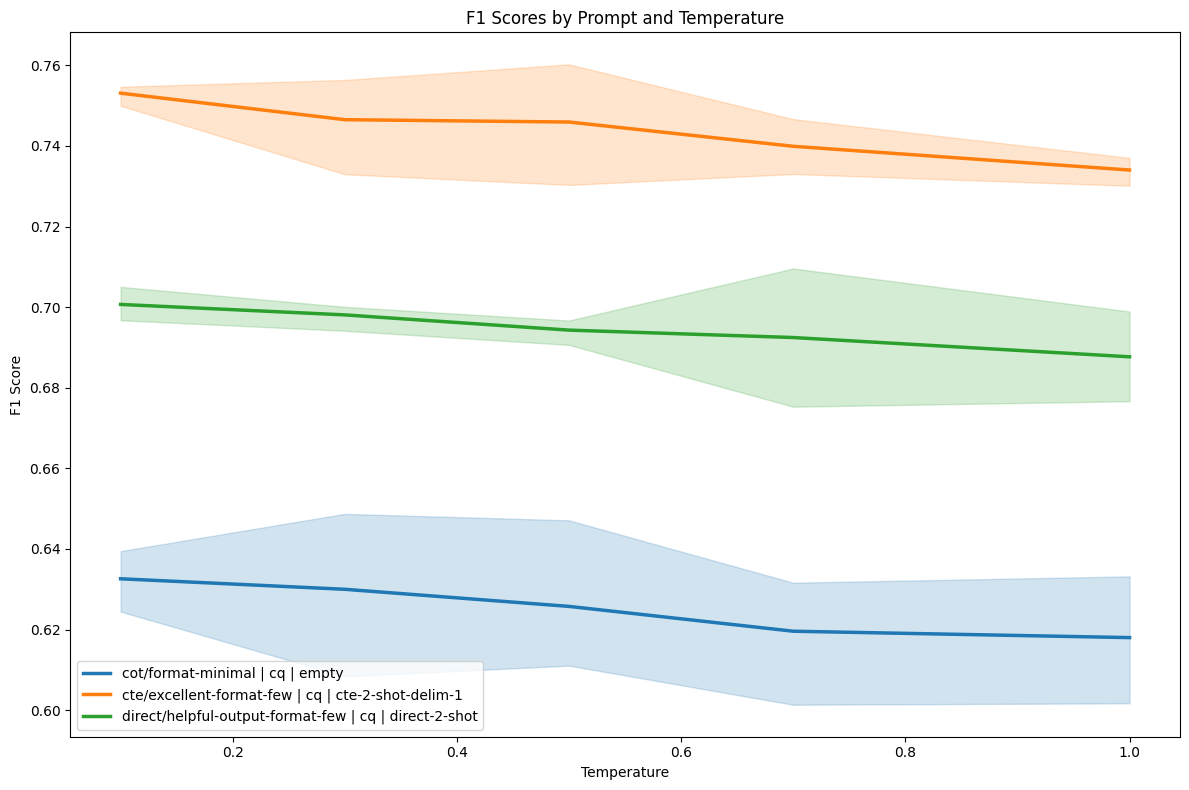

In [161]:
plot_variance(best_prepared_data, figsize=(12, 8))

In [158]:
# Two-Way ANOVA
two_way_anova(best_prepared_data)

Two-Way ANOVA Results:
                            sum_sq    df           F        PR(>F)
C(prompt)                 0.106741   2.0  358.873051  1.123328e-21
C(temperature)            0.001352   4.0    2.272255  8.472898e-02
C(prompt):C(temperature)  0.000064   8.0    0.054208  9.998925e-01
Residual                  0.004461  30.0         NaN           NaN


In [159]:
# Perform One-Way ANOVA by Temperature
one_way_anova_by_temperature(best_prepared_data)

One-Way ANOVA for Temperature 0.1:
F-statistic: 400.6326, p-value: 4.1059e-07
One-Way ANOVA for Temperature 0.3:
F-statistic: 53.9634, p-value: 1.4608e-04
One-Way ANOVA for Temperature 0.5:
F-statistic: 55.1223, p-value: 1.3751e-04
One-Way ANOVA for Temperature 0.7:
F-statistic: 55.2786, p-value: 1.3641e-04
One-Way ANOVA for Temperature 1.0:
F-statistic: 79.7144, p-value: 4.7711e-05


In [160]:
# Tukey’s HSD
tukey = pairwise_tukeyhsd(endog=best_prepared_data['f1'], groups=best_prepared_data['prompt'], alpha=0.005)
print(tukey)


                                             Multiple Comparison of Means - Tukey HSD, FWER=0.01                                              
                      group1                                               group2                        meandiff p-adj  lower   upper  reject
----------------------------------------------------------------------------------------------------------------------------------------------
                   cot/format-minimal | cq | empty    cte/excellent-format-few | cq | cte-2-shot-delim-1   0.1187   0.0  0.1043  0.1331   True
                   cot/format-minimal | cq | empty direct/helpful-output-format-few | cq | direct-2-shot   0.0695   0.0  0.0551  0.0839   True
cte/excellent-format-few | cq | cte-2-shot-delim-1 direct/helpful-output-format-few | cq | direct-2-shot  -0.0493   0.0 -0.0637 -0.0349   True
----------------------------------------------------------------------------------------------------------------------------------------------

## Inspect

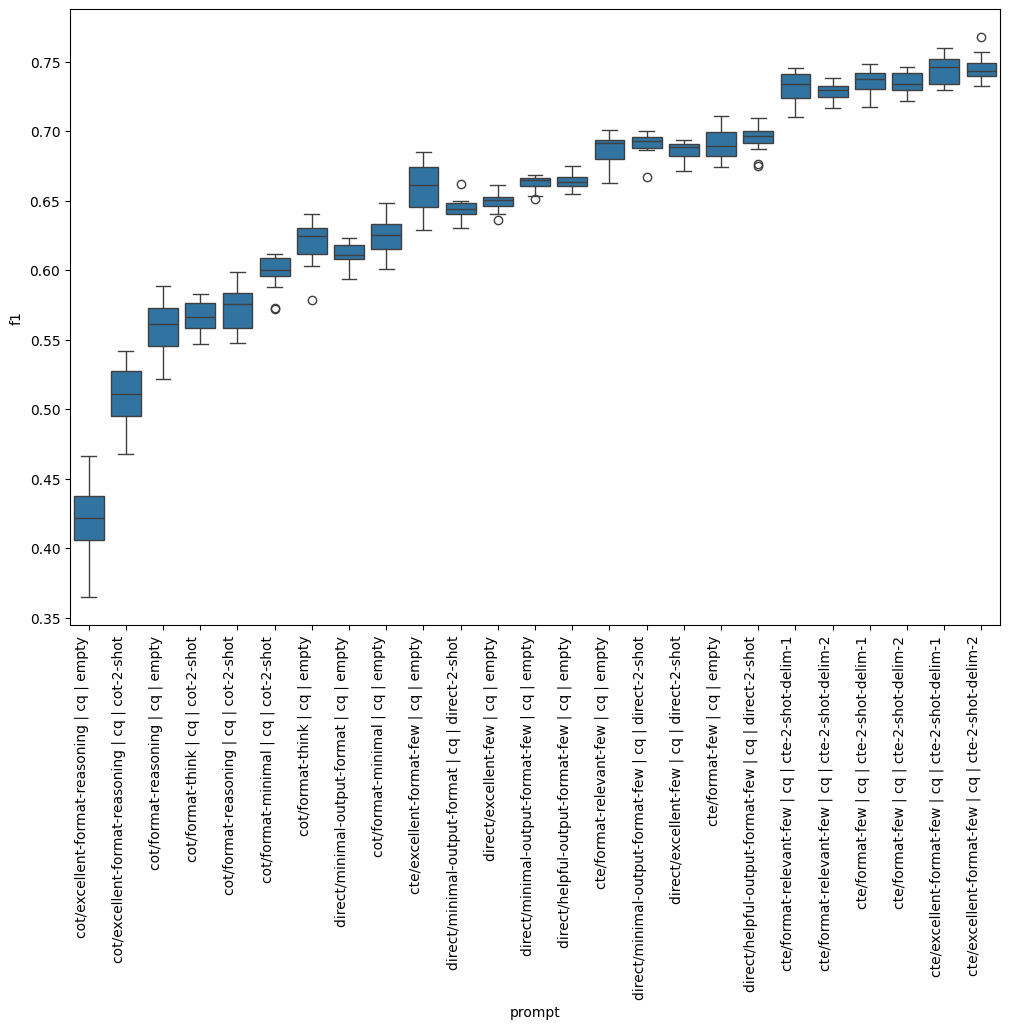

In [164]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=90, ha="right");